# Feature Engineering

### On `Mobile money` transactions for `Mara Bank`

## Sections in this notebook.


- Introduction
    - Project Overview
    - Objectives
    - Dataset Background

- Data Importation
    - Loading Required Libraries
    - Reading Data Files
    - Initial Data Preview

- Feature Creation
    - Dimensionality Reduction
    - Rolling Averages
    - Relationship Features
    - Fraud Detectors
    - Clustering

- Feature Transformation
    - Encoding
    - Normalization

- Feature Selection
    - Correlation

- Insights and Findings
    - Key Patterns
    - Anomalies
    - Business Insights
    - Recommendations

## Introduction

- Project Overview
- Objectives
- Dataset Background

### Project Overview

Imagine millions of transactions flowing every second through Mara Bank’s mobile money platform from airtime purchases, bill payments, transfers, and more; connecting people from Lagos to remote villages.

Within this constant flow are subtle signals: timing quirks, unusual transaction amounts, sudden changes in behavior. These signals aren’t always obvious, but they can make or break a fraud detection model.

This project focuses on feature engineering, turning raw transaction logs into meaningful variables that a machine can actually learn from.

### Project Objective

The Key objectives are:

- Refine the raw data: Ensure consistency, handle missing values, and normalize fields so features can be reliably created.

- Craft behavioral features: Capture user transaction habits (frequency, average amount, peak transaction hours, device/location patterns).

- Build anomaly indicators: Engineer flags for rare or suspicious events (sudden spikes in amount, rapid-fire transactions, cross-location jumps).

- Time-based intelligence: Generate features from transaction timestamps (day-of-week trends, session bursts, time since last activity).

- Transaction network insights: Create features linking users, merchants, and recipients to reveal unusual transaction paths or dense clusters.

The ultimate goal: design a strong feature set that maximizes the model’s ability to distinguish normal activity from fraud in real time.

### Background of Dataset

The dataset was generated mimicing the different scenerios transactions can occur in Nigeria. It contains transactions of diferrent banks, however we will be focusing on the transactions that belongs to `Mara Bank` for this project.

This dataset contains the following:

- `amount`: The value of the transaction.
- `balance`: The account balance after the transaction.
- `time`: The timestamp of the transaction.
- `holder`: The account number of the transaction's initiator or recipient.
- `kyc`: The kyc level of the account
- `holder_bvn`: The BVN of the transaction's initiator or recipient.
- `holder_bank`: The bank of the related party.
- `related`: The account number or entity related to the transaction (e.g., recipient account, ATM bank).
- `related_bvn`: The BVN of the related party.
- `related_bank`: The bank of the related party.
- `state`, `latitude`, `longitude`: Location details of the transaction.
- `status`: The outcome of the transaction (e.g., 'SUCCESS', 'FAILED').
- `type`: The transaction type (e.g., 'DEBIT', 'CREDIT').
- `category`: The specific class of transaction (e.g., 'OPENING', 'WITHDRAWAL', 'PAYMENT', 'TRANSFER', 'REVERSAL', 'BILL').
- `channel`: The channel used for the transaction (e.g., 'CARD', 'APP', 'USSD').
- `device`: The device used for the transaction (e.g., 'ATM-001', 'MOBILE-003') .
- `nonce`: A unique identifier for related transactions.
- `reported`: Marks reported transactions?
- `kyc`: The kyc leve of the holder
- `merchant`: Is the holder a POS operator
- `hour`: The hour of the transaction
- `week_day`: The day of the week for the transaction
- `month`: The month of the transaction
- `month_day`: The day of the month for the transaction
- `date`: The date of the transaction

## Data Importation

- Loading Required Libraries
- Reading Data Files
- Initial Data Preview

### Loading required libraries

In [591]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [592]:
# Import modules

import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [593]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [594]:
from lib import tracker, engineer, analyst, detector

### Reading data files

In [595]:
# Load the transactions dataset for the project 
df = pd.read_csv('../datasets/analyzed_transactions.csv', parse_dates=['time'])

### Initial data preview

In [596]:
# Preview the dataset
df.head()

,amount,balance,time,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,...,merchant,holder_state,holder_latitude,holder_longitude,opening_device,hour,week_day,month,date,month_day
0,607502.65,607502.65,2024-09-07 09:48:49.133128,ACC_0000000179,USER_000000000179,BANK_00003,BANK_00003,BANK_00003,Imo,10.62,...,False,Imo,10.62,3.72,MOBILE_00179_00001,9,Saturday,September,2024-09-07,7
1,827612.62,827612.62,2024-09-07 09:49:47.133128,ACC_0000000207,USER_000000000207,BANK_00003,BANK_00003,BANK_00003,Benue,10.89,...,False,Benue,10.89,4.37,MOBILE_00207_00001,9,Saturday,September,2024-09-07,7
2,318279.43,318279.43,2024-09-07 09:56:25.133128,ACC_0000000365,USER_000000000365,BANK_00003,BANK_00003,BANK_00003,Adamawa,6.28,...,True,Adamawa,6.28,4.45,MOBILE_00365_00002,9,Saturday,September,2024-09-07,7
3,92735.45,92735.45,2024-09-07 09:58:03.133128,ACC_0000000401,USER_000000000401,BANK_00003,BANK_00003,BANK_00003,Cross River,9.28,...,False,Cross River,9.28,5.02,MOBILE_00401_00001,9,Saturday,September,2024-09-07,7
4,109180.63,109180.63,2024-09-07 10:00:02.133128,ACC_0000000446,USER_000000000446,BANK_00003,BANK_00003,BANK_00003,Kano,11.97,...,False,Kano,11.97,8.58,MOBILE_00446_00001,10,Saturday,September,2024-09-07,7


In [597]:
# Set the format for pandas to display floats
pd.set_option('display.float_format', '{:.2f}'.format)

# Set the theme for our visualization
plt.style.use('dark_background')
sns.set_theme(style="darkgrid")

## Feature Creation

- Dimensionality Reduction
- Rolling Averages
- Relationship Features
- Fraud Detectors
- Clustering

### Dimensionality Reduction

We will reducing the dimensions of any categorical column that requires it. eg. `fraudulence`.

In [598]:
# Let's name our dataset
df_dimensioned = df.copy()

In [599]:
# What are the categorical columns
print(df_dimensioned.dtypes.to_frame())

                               0
amount                   float64
balance                  float64
time              datetime64[ns]
holder                    object
holder_bvn                object
related                   object
related_bvn               object
related_bank              object
state                     object
latitude                 float64
longitude                float64
status                    object
type                      object
category                  object
channel                   object
device                    object
nonce                     object
reported                    bool
kyc                        int64
merchant                    bool
holder_state              object
holder_latitude          float64
holder_longitude         float64
opening_device            object
hour                       int64
week_day                  object
month                     object
date                      object
month_day                  int64


While exploring our dataset, we noticed that most of the transactions are of the category of `withdrawal` and `deposit`.

<Axes: xlabel='category'>

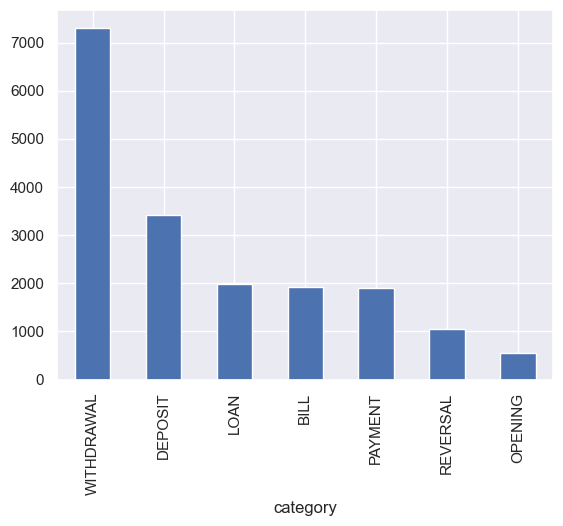

In [600]:
# Visualize the distribution of category
df_dimensioned['category'].value_counts().plot(kind='bar')

The difference is too big, and can confuse the machine learning model.

Most of this transactions that have been categorized as `withdrawal` or `deposit` are actually mobile transfers.

Hence we are going to reduce dimension of the `category` feature by renaming these categories as withdrawal.

<Axes: xlabel='category'>

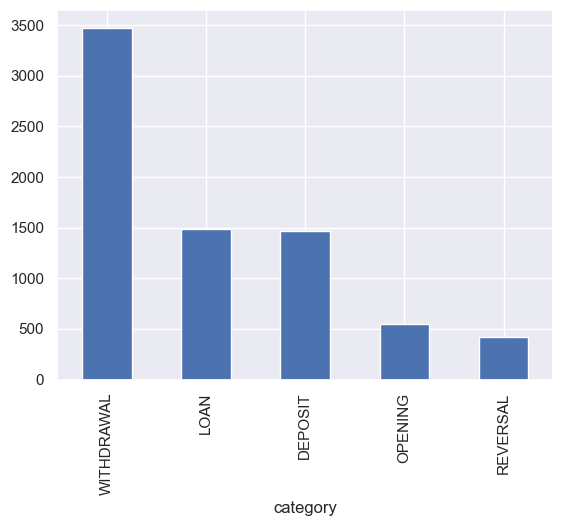

In [601]:
# Visualize the distribution of category of transactions made using the APP channel
df_dimensioned[df_dimensioned['channel'] == 'APP']['category'].value_counts().plot(kind='bar')

In [602]:
# Change mobile withdrawals to transfer
df_dimensioned.loc[(df_dimensioned['channel'] == 'APP') & (df_dimensioned['category'] == 'WITHDRAWAL'), 'category'] = 'TRANSFER'

# Change mobile deposits to transfer
df_dimensioned.loc[(df_dimensioned['channel'] == 'APP') & (df_dimensioned['category'] == 'DEPOSIT'), 'category'] = 'TRANSFER'

<Axes: xlabel='category'>

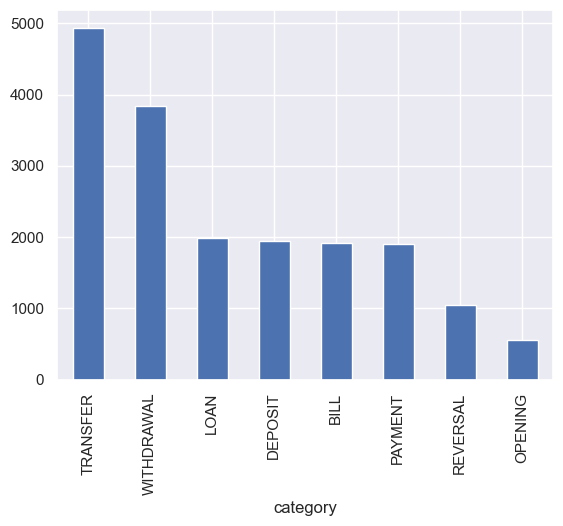

In [603]:
# Visualize the distribution of category
df_dimensioned['category'].value_counts().plot(kind='bar')

### Relating Features

There are alot of relationships between our features like:

- `holder` and `related`. This can be 1 person or a beneficiary.

- `device` and (`holder`/`holder_bvn`), does the device belong to this holder?

- `channel` and (`holder`/`holder_bvn`), how frequent does this user transact using this channel?

- `time` and (`holder`/`holder_bvn`), Is this an unusual time for this user to perform such type of transaction?

- `location` and (`holder`/`holder_bvn`), Is this location too far from the users normal or last known location?

- `amount` and (`holder`/`holder_bvn`), Is this a weird amoumnt for this user.

- `balance` and (`holder`/`holder_bvn`), What is the frequency of this user having this range of balance?

- `reported` and (`holder`/`holder_bvn`), Any reported transaction is a red flag, multiple reported transaction for a user, the user is doing something we should investigate.

- `reversals` and (`holder`/`holder_bvn`), Does the user frequently reverse transactions?

- `device` and `reversals`, is this device prune to reversing transactions?

- `amount`, `balance` and `user`.

In [604]:
# Name our dataset
df_engr = df_dimensioned.copy()

In [605]:
# Mark transactions where both the holder_bvn and related_bvn are the same (Same individual)
df_engr['sub_account'] = df_engr['holder_bvn'] == df_engr['related_bvn']

In [606]:
# How many times did this situation occur?
df_engr['sub_account'].value_counts()

sub_account
False    18124
True         1
Name: count, dtype: int64

Observation:

Only one user transacted with a `sub_account`.

What is the relationship between the `amount` and `balance`

- Mark transactions with large `amount`; From 100000.
- Mark situations when `balance` got drained or pumped.
- Then determine situations when `amount` is large and `balance` got drained or pumped.

In [607]:
transaction_limits = {1: 50_000, 2: 100_000, 3: 500_000, 4: 1_000_000}

In [608]:
df_engr['large_amount'] = df_engr[['kyc', 'amount']].apply(
    lambda trx: 
    transaction_limits[trx['kyc']] < trx['amount'], 
    axis=1
)

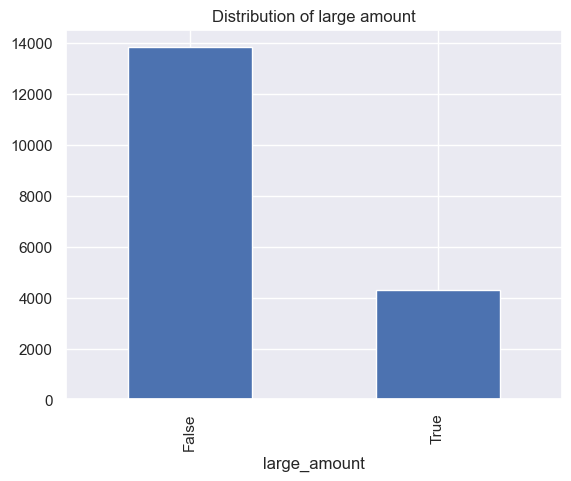

In [609]:
plt.title('Distribution of large amount')
df_engr['large_amount'].value_counts().plot(kind='bar');

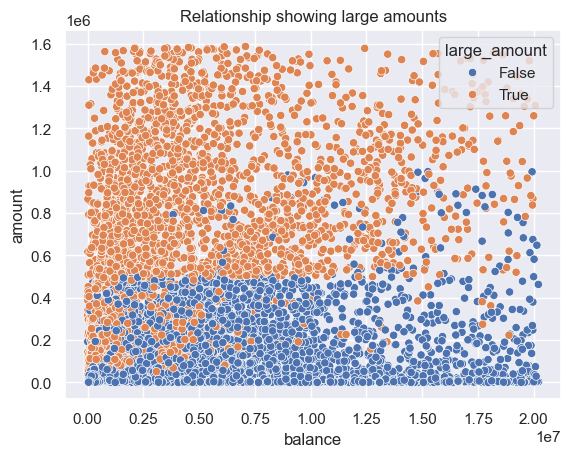

In [610]:
plt.title('Relationship showing large amounts')
sns.scatterplot(data=df_engr, x='balance', y='amount', hue='large_amount');

In [611]:
df_engr['balance_jump'] = df_engr.apply(
    lambda row: -row['amount'] if row['type'] == 'DEBIT' else row['amount'],
    axis=1
)

In [612]:
df_engr['previous_balance'] = df_engr.apply(
    lambda row: row['balance'] - row['balance_jump'],
    axis=1
)

In [613]:
df_engr['balance_jump_rate'] = df_engr.apply(
    lambda row: row['balance_jump'] / max(row['previous_balance'], 1),
    axis=1
)

In [614]:
df_engr['balance_jump_rate_absolute'] = df_engr.apply(
    lambda row: abs(row['balance_jump_rate']),
    axis=1
)

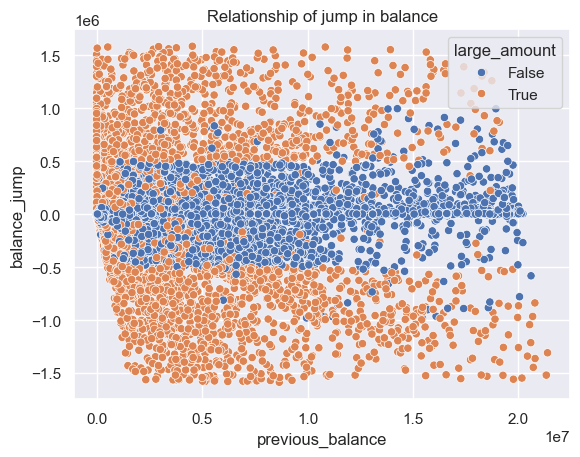

In [615]:
plt.title('Relationship of jump in balance')
sns.scatterplot(data=df_engr, x='previous_balance', y='balance_jump', hue='large_amount');

In [616]:
df_engr['drained_balance'] = df_engr['balance_jump_rate'] < -.9

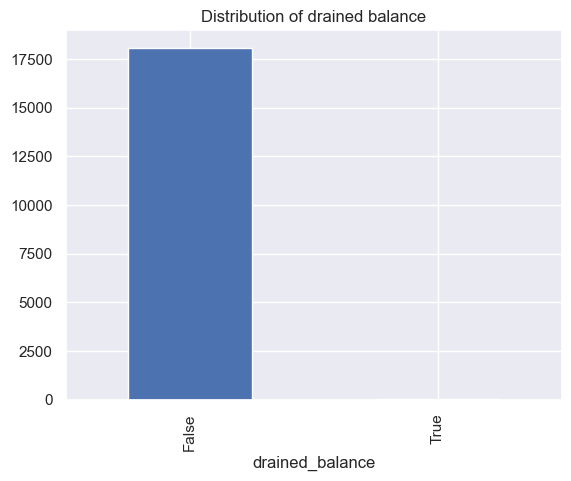

In [617]:
plt.title('Distribution of drained balance')
df_engr['drained_balance'].value_counts().plot(kind='bar');

Wow, no balance got drained.

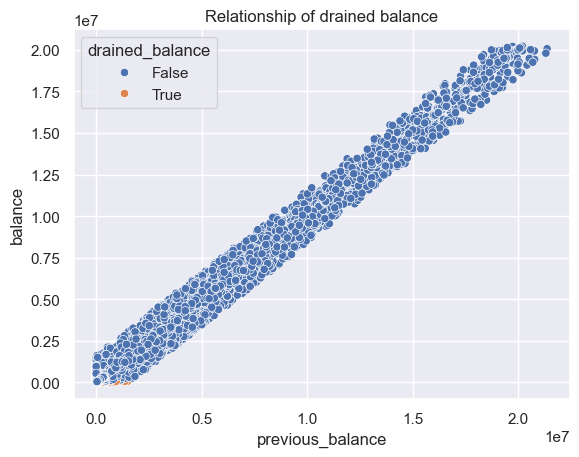

In [618]:
plt.title('Relationship of drained balance')
sns.scatterplot(data=df_engr, x='previous_balance', y='balance', hue='drained_balance');

In [619]:
df_engr['pumped_balance'] = df_engr['balance_jump_rate'] > .9

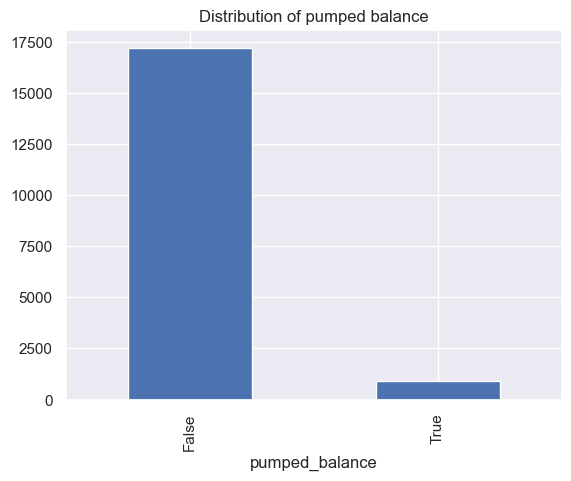

In [620]:
plt.title('Distribution of pumped balance')
df_engr['pumped_balance'].value_counts().plot(kind='bar');

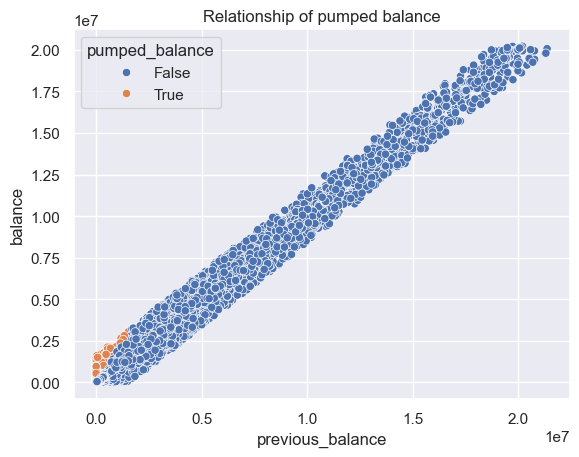

In [621]:
plt.title('Relationship of pumped balance')
sns.scatterplot(data=df_engr, x='previous_balance', y='balance', hue='pumped_balance');

In [622]:
df_engr['large_amount_drain'] = df_engr['large_amount'] & df_engr['drained_balance']

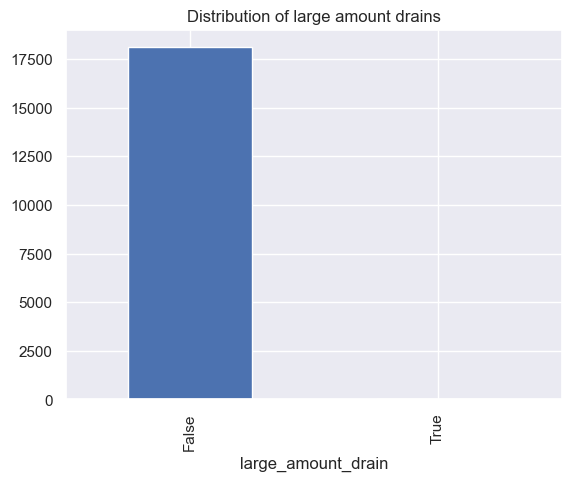

In [623]:
plt.title('Distribution of large amount drains')
df_engr['large_amount_drain'].value_counts().plot(kind='bar');

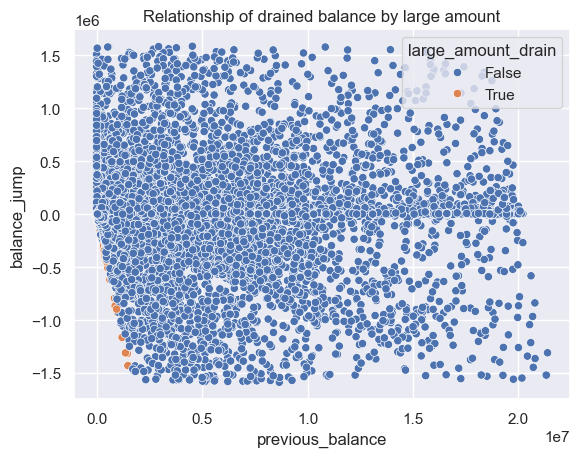

In [624]:
plt.title('Relationship of drained balance by large amount')
sns.scatterplot(data=df_engr, x='previous_balance', y='balance_jump', hue='large_amount_drain');

In [625]:
df_engr['large_amount_pump'] = df_engr['large_amount'] & df_engr['pumped_balance']

<Axes: title={'center': 'Distribution of pumped balance by large amount'}, xlabel='large_amount_pump'>

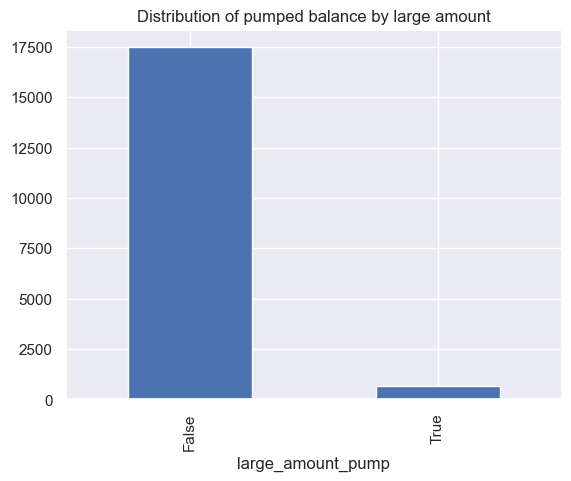

In [626]:
plt.title('Distribution of pumped balance by large amount')
df_engr['large_amount_pump'].value_counts().plot(kind='bar')

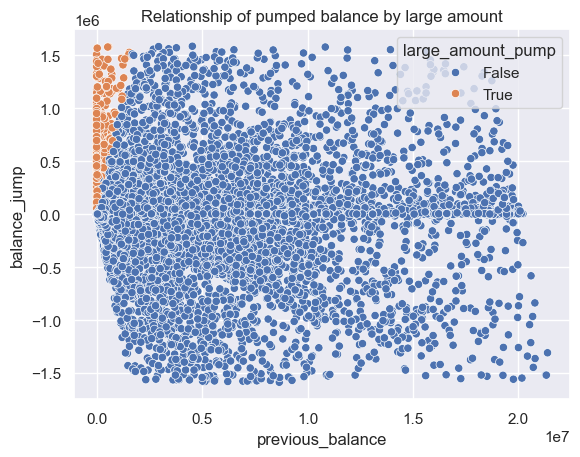

In [627]:
plt.title('Relationship of pumped balance by large amount')
sns.scatterplot(data=df_engr, x='previous_balance', y='balance_jump', hue='large_amount_pump');

In [628]:
df_engr

,amount,balance,time,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,...,sub_account,large_amount,balance_jump,previous_balance,balance_jump_rate,balance_jump_rate_absolute,drained_balance,pumped_balance,large_amount_drain,large_amount_pump
0,607502.65,607502.65,2024-09-07 09:48:49.133128,ACC_0000000179,USER_000000000179,BANK_00003,BANK_00003,BANK_00003,Imo,10.62,...,False,True,607502.65,0.00,607502.65,607502.65,False,True,False,True
1,827612.62,827612.62,2024-09-07 09:49:47.133128,ACC_0000000207,USER_000000000207,BANK_00003,BANK_00003,BANK_00003,Benue,10.89,...,False,True,827612.62,0.00,827612.62,827612.62,False,True,False,True
2,318279.43,318279.43,2024-09-07 09:56:25.133128,ACC_0000000365,USER_000000000365,BANK_00003,BANK_00003,BANK_00003,Adamawa,6.28,...,False,True,318279.43,0.00,318279.43,318279.43,False,True,False,True
3,92735.45,92735.45,2024-09-07 09:58:03.133128,ACC_0000000401,USER_000000000401,BANK_00003,BANK_00003,BANK_00003,Cross River,9.28,...,False,True,92735.45,0.00,92735.45,92735.45,False,True,False,True
4,109180.63,109180.63,2024-09-07 10:00:02.133128,ACC_0000000446,USER_000000000446,BANK_00003,BANK_00003,BANK_00003,Kano,11.97,...,False,True,109180.63,0.00,109180.63,109180.63,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,160573.37,1200329.63,2025-09-07 07:11:46.133128,ACC_0000038470,USER_000000019655,ACC_0000032034,USER_000000000347,BANK_00029,FCT,9.16,...,False,False,-160573.37,1360903.00,-0.12,0.12,False,False,False,False
18121,1586.77,18558.00,2025-09-07 07:14:07.133128,ACC_0000016534,USER_000000002098,BANK_00003,BANK_00003,BANK_00003,Oyo,8.07,...,False,False,1586.77,16971.23,0.09,0.09,False,False,False,False
18122,3223.84,112389.73,2025-09-07 07:14:08.133128,ACC_0000016724,USER_000000002417,ACC_0000022304,USER_000000011536,BANK_00018,Ondo,8.47,...,False,False,-3223.84,115613.57,-0.03,0.03,False,False,False,False
18123,6571.05,59575.95,2025-09-07 08:44:47.133128,ACC_0000037006,USER_000000003396,ATM_0000000063,ATM_0000000063,BANK_00031,Ekiti,6.87,...,False,False,-6571.05,66147.00,-0.10,0.10,False,False,False,False


What is the frequency between the `user` and the following?

`location`

We will determine this with the help of a special function called `distance_from_home` from the `engineer` module.

`distance_from_home` simply `calculates` how many the distance between the `last transaction` and the `current transaction`

In [629]:
df_engr['distance_from_home (km)'] = tracker.hound(df_engr[['holder', 'latitude', 'longitude', 'holder_latitude', 'holder_longitude', 'time']], lambda d,t: engineer.distance_from_home(d, t, 'holder'))

/Users/kennedyikeka/Documents/workshop/money_hound/lib/tracker.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  history = pd.concat([history, new_row], ignore_index=True)


In [630]:
df_engr['far_distance'] = df_engr['distance_from_home (km)'] >= 500

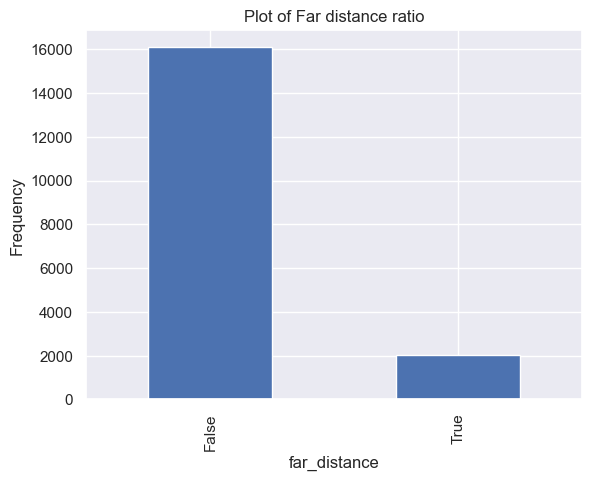

In [631]:
plt.title('Plot of Far distance ratio')
plt.ylabel('Frequency')
plt.xlabel('Far Distance')
df_engr['far_distance'].value_counts().plot(kind='bar');

What is the frequency between the `user` and the following?

`related`, `device`, `channel`, `state`

We will determine this with the help of a special function called `get_count_relations_frequency` from the `engineer` module.

It simply `counts` how many times the `user` has had transactions with `similar` features to the current `transaction`.

In [632]:
df_relating = df_engr.copy()

In [633]:
# Get the frequency of features for holder
df_relating = engineer.get_count_relations_frequency(df_relating, 'holder', ['related', 'device', 'channel', 'state'])

In [634]:
# Get the frequency of features for holder_bvn
df_relating = engineer.get_count_relations_frequency(df_relating, 'holder_bvn', ['related_bvn', 'device', 'channel', 'state'])

<Axes: xlabel='holder_device_count_frequency'>

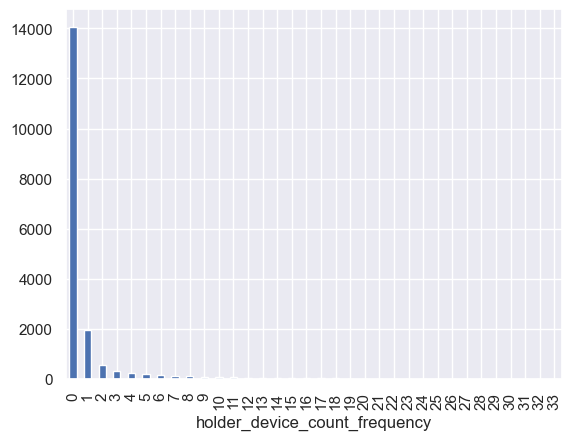

In [635]:
df_relating['holder_device_count_frequency'].value_counts().plot(kind='bar')

In [636]:
df_relating['is_opening_device'] = df_relating['device'] == df_relating['opening_device']

What is the frequency between the `holder` and the following?

`hour`, `amount`, `balance`, `balance_jump` and `balance_jump_rate`

We will determine this with the help of a special function called `get_bound_relations_frequency` from the `engineer` module.

It simply `counts` how many times the `user` has had transactions with features `around` the features of the current `transaction`.

In [637]:
# Get the frequency of features around the current transaction features for holder
df_relating = engineer.get_bounds(df_relating)

What is the frequency between the `user` and the occurance of the following?

`REVERSAL` and `REPORTED`

We will determine this with the help of a special function called `get_occurance` from the `engineer` module.

It simply `calculates` how many the a `unique` kind of situation has occured in the past.


In [638]:
# Get the number of time the events occured for holder
df_relating = engineer.get_holder_occurance(df_relating)

In [639]:
# Get the number of time the events occured for holder bvn
df_relating = engineer.get_holder_bvn_occurance(df_relating)

In [640]:
# Get the number of time the events occured for related
df_relating = engineer.get_related_occurance(df_relating)

In [641]:
# Get the number of time the events occured for related_bvn
df_relating = engineer.get_related_bvn_occurance(df_relating)

In [642]:
df_relating

,amount,balance,time,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,...,holder_large_amount_drain_True_occurance,holder_large_amount_pump_True_occurance,holder_far_distance_True_occurance,holder_bvn_reported_True_occurance,holder_bvn_category_REVERSAL_occurance,holder_bvn_far_distance_True_occurance,related_reported_True_occurance,related_category_REVERSAL_occurance,related_bvn_reported_True_occurance,related_bvn_category_REVERSAL_occurance
0,607502.65,607502.65,2024-09-07 09:48:49.133128,ACC_0000000179,USER_000000000179,BANK_00003,BANK_00003,BANK_00003,Imo,10.62,...,0,0,0,0,0,0,0,0,0,0
1,827612.62,827612.62,2024-09-07 09:49:47.133128,ACC_0000000207,USER_000000000207,BANK_00003,BANK_00003,BANK_00003,Benue,10.89,...,0,0,0,0,0,0,0,0,0,0
2,318279.43,318279.43,2024-09-07 09:56:25.133128,ACC_0000000365,USER_000000000365,BANK_00003,BANK_00003,BANK_00003,Adamawa,6.28,...,0,0,0,0,0,0,0,0,0,0
3,92735.45,92735.45,2024-09-07 09:58:03.133128,ACC_0000000401,USER_000000000401,BANK_00003,BANK_00003,BANK_00003,Cross River,9.28,...,0,0,0,0,0,0,0,0,0,0
4,109180.63,109180.63,2024-09-07 10:00:02.133128,ACC_0000000446,USER_000000000446,BANK_00003,BANK_00003,BANK_00003,Kano,11.97,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,160573.37,1200329.63,2025-09-07 07:11:46.133128,ACC_0000038470,USER_000000019655,ACC_0000032034,USER_000000000347,BANK_00029,FCT,9.16,...,0,0,0,1,0,0,0,0,2,0
18121,1586.77,18558.00,2025-09-07 07:14:07.133128,ACC_0000016534,USER_000000002098,BANK_00003,BANK_00003,BANK_00003,Oyo,8.07,...,0,0,0,0,0,0,0,0,0,0
18122,3223.84,112389.73,2025-09-07 07:14:08.133128,ACC_0000016724,USER_000000002417,ACC_0000022304,USER_000000011536,BANK_00018,Ondo,8.47,...,0,0,0,0,0,0,0,0,0,0
18123,6571.05,59575.95,2025-09-07 08:44:47.133128,ACC_0000037006,USER_000000003396,ATM_0000000063,ATM_0000000063,BANK_00031,Ekiti,6.87,...,0,0,0,1,0,0,5,0,5,0


In [643]:
df_relating.isna().sum().value_counts()

0    78
Name: count, dtype: int64

### Rolling Averages

Let's get the rolling averages of `balance`, `amount`, `balance_jump` and `balance_jump_rate` for `days`, `week` and `month`.

In [644]:
df_rolling = tracker.get_rolling(df_relating)

In [645]:
df_rolling

,amount,balance,time,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,...,holder_amount_avg_120D,holder_balance_avg_120D,holder_balance_jump_avg_120D,holder_balance_jump_rate_avg_120D,holder_distance_from_home (km)_avg_120D,holder_holder_device_count_frequency_avg_120D,holder_holder_hour_bound_frequency_avg_120D,holder_holder_related_count_frequency_avg_120D,holder_holder_category_REVERSAL_occurance_avg_120D,holder_holder_reported_True_occurance_avg_120D
0,607502.65,607502.65,2024-09-07 09:48:49.133128,ACC_0000000179,USER_000000000179,BANK_00003,BANK_00003,BANK_00003,Imo,10.62,...,607502.65,607502.65,607502.65,607502.65,0.00,0.00,0.00,0.00,0.00,0.00
1,827612.62,827612.62,2024-09-07 09:49:47.133128,ACC_0000000207,USER_000000000207,BANK_00003,BANK_00003,BANK_00003,Benue,10.89,...,827612.62,827612.62,827612.62,827612.62,0.00,0.00,0.00,0.00,0.00,0.00
2,318279.43,318279.43,2024-09-07 09:56:25.133128,ACC_0000000365,USER_000000000365,BANK_00003,BANK_00003,BANK_00003,Adamawa,6.28,...,318279.43,318279.43,318279.43,318279.43,0.00,0.00,0.00,0.00,0.00,0.00
3,92735.45,92735.45,2024-09-07 09:58:03.133128,ACC_0000000401,USER_000000000401,BANK_00003,BANK_00003,BANK_00003,Cross River,9.28,...,92735.45,92735.45,92735.45,92735.45,0.00,0.00,0.00,0.00,0.00,0.00
4,109180.63,109180.63,2024-09-07 10:00:02.133128,ACC_0000000446,USER_000000000446,BANK_00003,BANK_00003,BANK_00003,Kano,11.97,...,109180.63,109180.63,109180.63,109180.63,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,160573.37,1200329.63,2025-09-07 07:11:46.133128,ACC_0000038470,USER_000000019655,ACC_0000032034,USER_000000000347,BANK_00029,FCT,9.16,...,254124.98,1489471.05,-247735.69,-0.13,124.60,0.00,0.00,0.00,0.00,0.25
18121,1586.77,18558.00,2025-09-07 07:14:07.133128,ACC_0000016534,USER_000000002098,BANK_00003,BANK_00003,BANK_00003,Oyo,8.07,...,10963.20,32987.47,634.35,3670.36,121.52,0.33,0.52,0.86,0.05,1.00
18122,3223.84,112389.73,2025-09-07 07:14:08.133128,ACC_0000016724,USER_000000002417,ACC_0000022304,USER_000000011536,BANK_00018,Ondo,8.47,...,77767.73,284363.65,-17915.45,22061.92,146.27,0.28,0.88,0.28,0.00,0.04
18123,6571.05,59575.95,2025-09-07 08:44:47.133128,ACC_0000037006,USER_000000003396,ATM_0000000063,ATM_0000000063,BANK_00031,Ekiti,6.87,...,27630.31,59779.14,14894.11,16536.87,0.00,0.25,0.25,0.25,0.00,0.25


In [646]:
df_rolling.isna().sum().sort_values()

amount                                            0
holder_holder_related_count_frequency_avg_1D      0
holder_holder_hour_bound_frequency_avg_1D         0
holder_holder_device_count_frequency_avg_1D       0
holder_distance_from_home (km)_avg_1D             0
                                                 ..
balance_jump_rate                                 0
previous_balance                                  0
balance_jump                                      0
holder_device_count_frequency                     0
holder_holder_reported_True_occurance_avg_120D    0
Length: 118, dtype: int64

In [647]:
df_rolling.to_csv(f'../datasets/engineered_transactions.csv', index=False)

## Feature Transformation

In [648]:
# Naming our dataset
df_transformed = df_rolling.copy()

In [649]:
# Drop the time feature, we have extracted everything from it.
df_transformed.drop(columns='time', inplace=True)

### Feature Encoding

We will encode our discrete features so our future models will learn well from our dataset.

This will be done with the help of our special function `encoder` from `engineer` module.

It uses `LabelEncoder`.

In [650]:
# Encode the discrete features
discrete_features = df_transformed.select_dtypes(include=['object']).columns.tolist()
discrete_features

['holder',
 'holder_bvn',
 'related',
 'related_bvn',
 'related_bank',
 'state',
 'status',
 'type',
 'category',
 'channel',
 'device',
 'nonce',
 'holder_state',
 'opening_device',
 'week_day',
 'month',
 'date']

In [651]:
# Encode discrete features
encoded = engineer.encoder(df_transformed, discrete_features)
df_transformed[discrete_features] = encoded

In [652]:
# Preview the dataset
df_transformed

,amount,balance,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,longitude,...,holder_amount_avg_120D,holder_balance_avg_120D,holder_balance_jump_avg_120D,holder_balance_jump_rate_avg_120D,holder_distance_from_home (km)_avg_120D,holder_holder_device_count_frequency_avg_120D,holder_holder_hour_bound_frequency_avg_120D,holder_holder_related_count_frequency_avg_120D,holder_holder_category_REVERSAL_occurance_avg_120D,holder_holder_reported_True_occurance_avg_120D
0,607502.65,607502.65,1,16,7340,96,3,16,10.62,3.72,...,607502.65,607502.65,607502.65,607502.65,0.00,0.00,0.00,0.00,0.00,0.00
1,827612.62,827612.62,2,18,7340,96,3,6,10.89,4.37,...,827612.62,827612.62,827612.62,827612.62,0.00,0.00,0.00,0.00,0.00,0.00
2,318279.43,318279.43,4,41,7340,96,3,1,6.28,4.45,...,318279.43,318279.43,318279.43,318279.43,0.00,0.00,0.00,0.00,0.00,0.00
3,92735.45,92735.45,5,46,7340,96,3,8,9.28,5.02,...,92735.45,92735.45,92735.45,92735.45,0.00,0.00,0.00,0.00,0.00,0.00
4,109180.63,109180.63,6,54,7340,96,3,19,11.97,8.58,...,109180.63,109180.63,109180.63,109180.63,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,160573.37,1200329.63,750,746,6982,362,29,14,9.16,3.95,...,254124.98,1489471.05,-247735.69,-0.13,124.60,0.00,0.00,0.00,0.00,0.25
18121,1586.77,18558.00,320,213,7340,96,3,30,8.07,3.41,...,10963.20,32987.47,634.35,3670.36,121.52,0.33,0.52,0.86,0.05,1.00
18122,3223.84,112389.73,322,237,6066,4612,18,28,8.47,5.97,...,77767.73,284363.65,-17915.45,22061.92,146.27,0.28,0.88,0.28,0.00,0.04
18123,6571.05,59575.95,728,293,7306,62,31,12,6.87,3.59,...,27630.31,59779.14,14894.11,16536.87,0.00,0.25,0.25,0.25,0.00,0.25


### Feature Normalization

We will encode our discrete features so our future models will learn well from our dataset.

This will be done with the help of our special function `encoder` from `engineer` module.

It uses `MinMaxScaler`.

In [653]:
# Normalize the dataset
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_transformed)

In [654]:
# replace the encoded data with the normalized data
df_transformed = pd.DataFrame(scaled_data, columns=df_transformed.columns)

In [655]:
# Preview the dataframe
df_transformed

,amount,balance,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,longitude,...,holder_amount_avg_120D,holder_balance_avg_120D,holder_balance_jump_avg_120D,holder_balance_jump_rate_avg_120D,holder_distance_from_home (km)_avg_120D,holder_holder_device_count_frequency_avg_120D,holder_holder_hour_bound_frequency_avg_120D,holder_holder_related_count_frequency_avg_120D,holder_holder_category_REVERSAL_occurance_avg_120D,holder_holder_reported_True_occurance_avg_120D
0,2.80,0.02,-0.61,-0.72,0.38,-0.26,-0.67,-0.11,0.61,-0.29,...,1.65,-0.01,12.03,26.74,-0.86,-0.40,-0.66,-0.57,0.00,-0.27
1,3.87,0.09,-0.61,-0.72,0.38,-0.26,-0.67,-0.67,0.69,-0.11,...,2.44,0.06,16.39,36.49,-0.86,-0.40,-0.66,-0.57,0.00,-0.27
2,1.38,-0.07,-0.60,-0.64,0.38,-0.26,-0.67,-0.94,-0.61,-0.09,...,0.61,-0.10,6.30,13.94,-0.86,-0.40,-0.66,-0.57,0.00,-0.27
3,0.28,-0.14,-0.60,-0.62,0.38,-0.26,-0.67,-0.56,0.24,0.06,...,-0.20,-0.17,1.82,3.96,-0.86,-0.40,-0.66,-0.57,0.00,-0.27
4,0.36,-0.13,-0.60,-0.60,0.38,-0.26,-0.67,0.06,0.99,1.03,...,-0.14,-0.16,2.15,4.68,-0.86,-0.40,-0.66,-0.57,0.00,-0.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,0.61,0.21,2.19,1.71,0.31,-0.14,0.30,-0.22,0.20,-0.23,...,0.38,0.27,-4.93,-0.15,-0.09,-0.40,-0.66,-0.57,0.00,0.36
18121,-0.16,-0.16,0.58,-0.07,0.38,-0.26,-0.67,0.67,-0.10,-0.37,...,-0.49,-0.19,-0.00,0.01,-0.11,0.47,0.26,1.38,1.43,2.23
18122,-0.16,-0.13,0.59,0.01,0.12,1.84,-0.11,0.56,0.01,0.32,...,-0.26,-0.11,-0.37,0.83,0.04,0.33,0.88,0.07,0.00,-0.17
18123,-0.14,-0.15,2.11,0.20,0.38,-0.27,0.37,-0.33,-0.44,-0.32,...,-0.44,-0.18,0.28,0.58,-0.86,0.25,-0.22,0.00,0.00,0.36


## Anomaly Detection

Most transactions seem normal, and to uncover fraudulent pattern are hard.

That is why we will be beconing on a special sklearn estimator `Isolation Forest` that is wrapped inside our custom function `check_anomaly` within the engineer module. 

It will help classify between fraud and non-fraud transcations.

We will also get a score of how fraudulent the transactions are.

In [656]:
df_unsual = df_transformed.copy()

In [657]:
df_unsual = detector.unsual_amount(df_unsual)
df_unsual[['unsual_amount_score', 'unsual_amount']].corr()

,unsual_amount_score,unsual_amount
unsual_amount_score,1.00,0.89
unsual_amount,0.89,1.00


In [658]:
df_unsual = detector.unsual_balance(df_unsual)
df_unsual[['unsual_balance_score', 'unsual_balance']].corr()

,unsual_balance_score,unsual_balance
unsual_balance_score,1.00,0.85
unsual_balance,0.85,1.00


In [659]:
df_unsual = detector.unsual_location(df_unsual)
df_unsual[['unsual_location_score', 'unsual_location']].corr()

,unsual_location_score,unsual_location
unsual_location_score,1.00,0.84
unsual_location,0.84,1.00


In [660]:
df_unsual = detector.unsual_time(df_unsual)
df_unsual[['unsual_time_score', 'unsual_time']].corr()

,unsual_time_score,unsual_time
unsual_time_score,1.00,0.85
unsual_time,0.85,1.00


In [661]:
df_unsual = detector.unsual_device(df_unsual)
df_unsual[['unsual_device_score', 'unsual_device']].corr()

,unsual_device_score,unsual_device
unsual_device_score,1.00,0.88
unsual_device,0.88,1.00


In [662]:
# Classify transactions
df_classified = engineer.anomalize(df_unsual, 'fraud')

In [663]:
df_classified

,amount,balance,holder,holder_bvn,related,related_bvn,related_bank,state,latitude,longitude,...,unsual_balance_score,unsual_balance,unsual_location_score,unsual_location,unsual_time_score,unsual_time,unsual_device_score,unsual_device,fraud_score,fraud
0,2.80,0.02,-0.61,-0.72,0.38,-0.26,-0.67,-0.11,0.61,-0.29,...,0.92,True,0.00,False,0.00,False,0.63,True,0.58,True
1,3.87,0.09,-0.61,-0.72,0.38,-0.26,-0.67,-0.67,0.69,-0.11,...,0.95,True,0.00,False,0.00,False,0.63,True,0.72,True
2,1.38,-0.07,-0.60,-0.64,0.38,-0.26,-0.67,-0.94,-0.61,-0.09,...,0.85,True,0.00,False,0.00,False,0.63,True,0.55,True
3,0.28,-0.14,-0.60,-0.62,0.38,-0.26,-0.67,-0.56,0.24,0.06,...,0.74,True,0.00,False,0.00,False,0.63,True,0.40,False
4,0.36,-0.13,-0.60,-0.60,0.38,-0.26,-0.67,0.06,0.99,1.03,...,0.77,True,0.00,False,0.00,False,0.63,True,0.42,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18120,0.61,0.21,2.19,1.71,0.31,-0.14,0.30,-0.22,0.20,-0.23,...,0.07,False,0.02,False,0.00,False,0.01,False,0.14,False
18121,-0.16,-0.16,0.58,-0.07,0.38,-0.26,-0.67,0.67,-0.10,-0.37,...,0.03,False,0.07,False,0.05,False,0.08,False,0.19,False
18122,-0.16,-0.13,0.59,0.01,0.12,1.84,-0.11,0.56,0.01,0.32,...,0.01,False,0.09,False,0.29,True,0.07,False,0.15,False
18123,-0.14,-0.15,2.11,0.20,0.38,-0.27,0.37,-0.33,-0.44,-0.32,...,0.03,False,0.00,False,0.02,False,0.05,False,0.13,False


<Axes: title={'center': 'Fraud score distribution'}, ylabel='Frequency'>

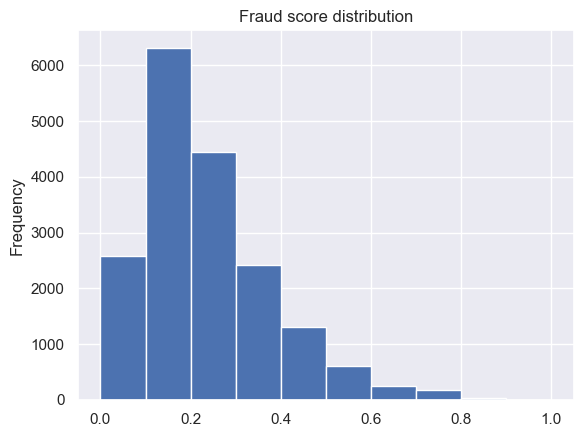

In [664]:
# Plot the fraud score
plt.title('Fraud score distribution')
df_classified['fraud_score'].plot(kind='hist')

Text(0, 0.5, 'Frequency')

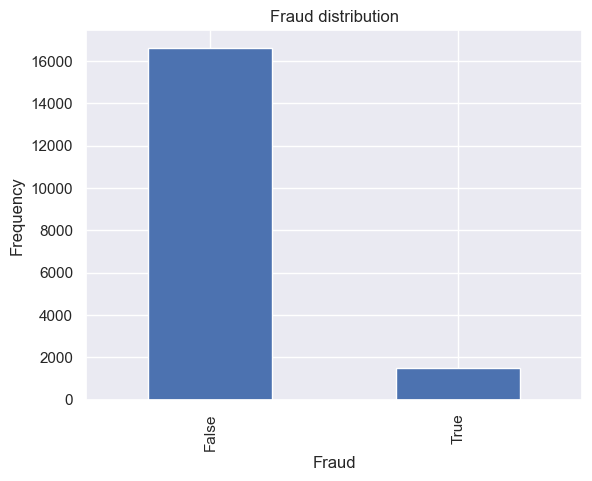

In [665]:
# Plot of fraud distribution
plt.title('Fraud distribution')
df_classified['fraud'].value_counts().plot(kind='bar')
plt.xlabel('Fraud')
plt.ylabel('Frequency')

In [666]:
df_classified['fraud'].value_counts(normalize=True)

fraud
False   0.92
True    0.08
Name: proportion, dtype: float64

In [667]:
# What is the correlation between fraud and fraud_score
df_classified[['fraud_score', 'fraud']].corr()

,fraud_score,fraud
fraud_score,1.00,0.70
fraud,0.70,1.00


In [668]:
df_classified[df_classified['fraud'] == True].groupby('holder')['fraud'].value_counts().sort_values()

holder  fraud
0.54    True      1
1.07    True      1
1.06    True      1
        True      1
        True      1
                 ..
-0.57   True     34
-0.59   True     34
-0.54   True     43
-0.59   True     50
-0.08   True     53
Name: count, Length: 424, dtype: int64

In [669]:
# Save the dataset
df_classified.to_csv(f'../datasets/classified_transactions.csv', index=False)

## Key Insights and Recommendations

A whole lot more important features can still be engineered from this dataset like:
- Relationships between time and distance
- Did the other party report the transaction
- ...

Also alot more unsual relationships can still be captured, like:
- Relationships between the holder and related, holder_bvn and related_bvn.
- Unsual reversals
- Unsual reporting
- etc.


For now we will continue with the features we already have.
